In [22]:
import yfinance as yf
import pandas as pd
import numpy as np


# Download ~60 days M15 = 5000+ bars
ticker = 'EURUSD=X'
df = yf.download(ticker, period='60d', interval='15m', auto_adjust=False)
df = df[['Open', 'High', 'Low', 'Close']].dropna()
print(f"Loaded {len(df):,} M15 bars: {df.index[0].date()} to {df.index[-1].date()}")


[*********************100%***********************]  1 of 1 completed

Loaded 5,585 M15 bars: 2025-09-15 to 2025-12-05


In [24]:
import talib
import numpy as np
import pandas as pd

# Fix MultiIndex columns - extract just the price data
df.columns = [col[0] for col in df.columns]  # ['Open', 'High', 'Low', 'Close']

# Now convert to proper 1D arrays
close = df['C'].values
high = df['H'].values
low = df['L'].values

# TA-Lib will now work
macd, signal, hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['RSI'] = talib.RSI(close, timeperiod=14)
df['ATR'] = talib.ATR(high, low, close, timeperiod=14)

df = df.dropna().reset_index(drop=True)
print(f"After indicators: {len(df):,} bars")


After indicators: 5,552 bars


In [25]:
def generate_labels(df, mult=0.5, RR=2):
    results = []
    
    print(f"Processing multiplier {mult}...")
    labels = pd.Series(index=df.index, dtype=int)
    
    for i in range(1, len(df)):  # Start after indicator warmup, leave lookahead
        # ENTRY at OPEN of current bar i
        entry_price = df['O'].iloc[i]
        
        # FEATURES from PREVIOUS closed bar (i-1)
        prev_macd = df['MACD'].iloc[i-1]
        prev_rsi = df['RSI'].iloc[i-1]
        prev_atr = df['ATR'].iloc[i-1]
        
        # Skip if any feature NaN
        if pd.isna(prev_macd) or pd.isna(prev_rsi) or pd.isna(prev_atr):
            continue
            
        sl_distance = mult * prev_atr
        tp_distance = RR*mult * prev_atr
        
        # Simulate forward from CURRENT bar i+1 onwards
        future_bars = df.iloc[i+1:i+51]  # Max 50 bars lookahead
        if len(future_bars) < 5:  # Need minimum bars
            continue
            
        highs = future_bars['H']
        lows = future_bars['L']
        
        # Check BUY: TP hits before SL
        tp_buy_level = entry_price + tp_distance
        sl_buy_level = entry_price - sl_distance
        
        buy_tp_idx = highs[highs >= tp_buy_level].index.min() if (highs >= tp_buy_level).any() else None
        buy_sl_idx = lows[lows <= sl_buy_level].index.min() if (lows <= sl_buy_level).any() else None
        
        buy_win = False
        if buy_tp_idx is not None and buy_sl_idx is not None:
            buy_win = buy_tp_idx < buy_sl_idx  # TP first
        elif buy_tp_idx is not None:
            buy_win = True  # TP hit, no SL
        
        # Check SELL: SL (resistance) hits before TP (support)  
        tp_sell_level = entry_price - tp_distance
        sl_sell_level = entry_price + sl_distance
        
        sell_tp_idx = lows[lows <= tp_sell_level].index.min() if (lows <= tp_sell_level).any() else None
        sell_sl_idx = highs[highs >= sl_sell_level].index.min() if (highs >= sl_sell_level).any() else None
        
        sell_win = False
        if sell_tp_idx is not None and sell_sl_idx is not None:
            sell_win = sell_tp_idx < sell_sl_idx  # TP first
        elif sell_tp_idx is not None:
            sell_win = True  # TP hit, no SL
        
        # STRING LABELS: "buy", "sell", or NaN
        if buy_win and sell_win:
            labels.iloc[i] = 0  # Both win: neutral/do nothing
        elif buy_win:
            labels.iloc[i] = 1  # Buy only
        elif sell_win:
            labels.iloc[i] = -1  # Sell only
        else:
            labels.iloc[i] = 0  # Neither: neutral [web:2]
    
    results.append(labels.rename(f'label'))

    return pd.concat(results, axis=1)

# Generate labels
mult = 2
RR=2
labels_df = generate_labels(df ,mult, RR)
print("Label distribution:")
print(labels_df.apply(lambda x: x.value_counts(normalize=True)).round(3))
print("\nSample data:")
print(pd.concat([df[['MACD', 'RSI', 'ATR']], labels_df.iloc[:, 0]], axis=1).head(10))
print(pd.concat([df[['MACD', 'RSI', 'ATR']], labels_df.iloc[:, 0]], axis=1).tail(10))


Processing multiplier 2...
Label distribution:
       label
label       
 0.0   0.426
 1.0   0.295
-1.0   0.280

Sample data:
       MACD        RSI       ATR  label
0  0.000755  75.275793  0.000463    NaN
1  0.000758  67.365033  0.000509    1.0
2  0.000762  68.551749  0.000533    1.0
3  0.000779  70.835003  0.000544    1.0
4  0.000784  70.835003  0.000575    1.0
5  0.000734  60.625343  0.000584    1.0
6  0.000709  63.461127  0.000572    1.0
7  0.000759  71.267947  0.000621    1.0
8  0.000811  73.042335  0.000616    0.0
9  0.000910  77.529496  0.000632    0.0
          MACD        RSI       ATR  label
5542 -0.000144  46.086769  0.000438    0.0
5543 -0.000139  46.086769  0.000426    0.0
5544 -0.000122  48.727583  0.000415    0.0
5545 -0.000108  48.727583  0.000405    0.0
5546 -0.000084  51.486005  0.000396    0.0
5547 -0.000076  48.666385  0.000377    NaN
5548 -0.000079  45.958264  0.000379    NaN
5549 -0.000081  45.958264  0.000371    NaN
5550 -0.000081  45.958264  0.000345    NaN
5551

In [26]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np

# Split 20% test set (final 20% chronological)
test_size = int(len(df) * 0.2)
train_val_df = df.iloc[:-test_size].copy()
test_df = df.iloc[-test_size:].copy()

print(f"Train+Val: {len(train_val_df):,} bars, Test: {len(test_df):,} bars")

results = {}

#tscv = TimeSeriesSplit(n_splits=5)
# Fixed window: use max_train_size for constant training size, test_size for fixed test
tscv = TimeSeriesSplit(
    n_splits=10,          # Number of folds
    max_train_size=500,   # Fixed training window size (adjust to your needs)
    test_size=200          # Fixed test/validation size per fold
)

feature_cols = ['MACD', 'RSI']


label_col = f'label'

# Align train/val data
X = train_val_df[feature_cols].copy()
y = labels_df[label_col].loc[train_val_df.index].replace(0, np.nan).dropna()
X = X.loc[y.index]
    
# Initialize totals before loop
total_train_buys = 0
total_train_sells = 0
total_val_buys = 0
total_val_sells = 0

scores = []
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Count buys (1) and sells (-1) in train and val
    train_buys = (y_train == 1).sum()
    train_sells = (y_train == -1).sum()
    val_buys = (y_val == 1).sum()
    val_sells = (y_val == -1).sum()
    
    # Update totals
    total_train_buys += train_buys
    total_train_sells += train_sells
    total_val_buys += val_buys
    total_val_sells += val_sells
    
    print(f"Fold {fold_num}:")
    print(f"  Training set: {train_idx[0]}-{train_idx[-1]} ({len(train_idx)} samples)")
    print(f"    Buys: {train_buys}, Sells: {train_sells}")
    print(f"  Validation set: {val_idx[0]}-{val_idx[-1]} ({len(val_idx)} samples)")
    print(f"    Buys: {val_buys}, Sells: {val_sells}")
    print()
    
    model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=20, class_weight={-1:1, 1:1})
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    scores.append(score)

# Print totals after loop
print("Total counts across all folds:")
print(f"  Training buys: {total_train_buys}, Training sells: {total_train_sells}")
print(f"  Validation buys: {total_val_buys}, Validation sells: {total_val_sells}")


cv_score = np.mean(scores)
results[mult] = cv_score
print(f"CV Accuracy: {cv_score:.3f} (+/- {np.std(scores)*2:.3f})")

# === FINAL TEST EVALUATION ===
print(f"\n{'='*50}")
print(f"FINAL TEST: Multiplier {mult}")
print(f"{'='*50}")

# Prepare test set
X_test = test_df[feature_cols].copy()
y_test = labels_df[f'label'].loc[test_df.index].replace(0, np.nan).dropna()
X_test = X_test.loc[y_test.index]

# Train final model on ALL train+val data
X_final_train = train_val_df[feature_cols].copy()
y_final_train = labels_df[f'label'].loc[train_val_df.index].replace(0, np.nan).dropna()
X_final_train = X_final_train.loc[y_final_train.index]

final_model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=20, class_weight={-1:1, 1:1})
final_model.fit(X_final_train, y_final_train)

# Test predictions
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Sell', 'Buy']))
print(f"Test Accuracy: {final_model.score(X_test, y_test):.3f}")


Train+Val: 4,442 bars, Test: 1,110 bars
Fold 1:
  Training set: 95-594 (500 samples)
    Buys: 229, Sells: 271
  Validation set: 595-794 (200 samples)
    Buys: 133, Sells: 67

Fold 2:
  Training set: 295-794 (500 samples)
    Buys: 273, Sells: 227
  Validation set: 795-994 (200 samples)
    Buys: 53, Sells: 147

Fold 3:
  Training set: 495-994 (500 samples)
    Buys: 246, Sells: 254
  Validation set: 995-1194 (200 samples)
    Buys: 115, Sells: 85

Fold 4:
  Training set: 695-1194 (500 samples)
    Buys: 226, Sells: 274
  Validation set: 1195-1394 (200 samples)
    Buys: 133, Sells: 67

Fold 5:
  Training set: 895-1394 (500 samples)
    Buys: 282, Sells: 218
  Validation set: 1395-1594 (200 samples)
    Buys: 50, Sells: 150

Fold 6:
  Training set: 1095-1594 (500 samples)
    Buys: 260, Sells: 240
  Validation set: 1595-1794 (200 samples)
    Buys: 103, Sells: 97

Fold 7:
  Training set: 1295-1794 (500 samples)
    Buys: 208, Sells: 292
  Validation set: 1795-1994 (200 samples)
    Bu


SIMPLE EQUITY CURVE: Multiplier 2, Fixed 1% R/R
Total Trades: 590
Wins: 364 (61.7% win rate)
Final Balance: $127,600
Total Return: 27.6%
Max Drawdown: -5.6%

Trade Results:
Actual     -1.0   1.0   Total
Predicted                    
-1.0        146   129     275
 1.0         97   218     315
 Total      243   347     590


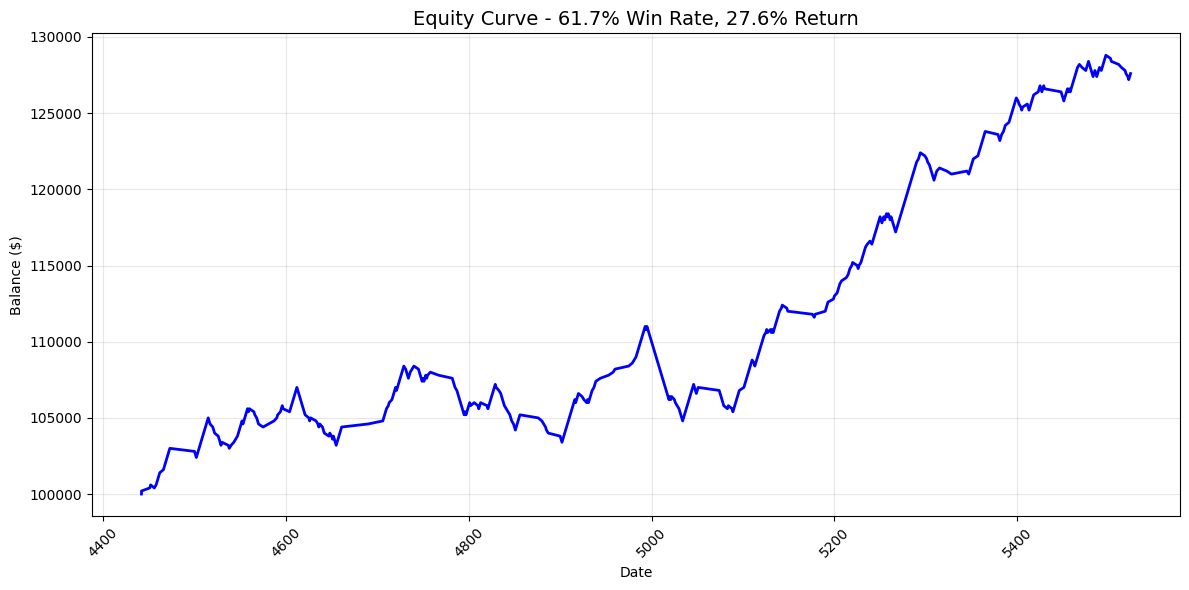

In [27]:
# === SIMPLE BALANCE CURVE (1% FIXED R/R) ===
print(f"\n{'='*60}")
print(f"SIMPLE EQUITY CURVE: Multiplier {mult}, Fixed 1% R/R")
print(f"{'='*60}")

risk_per_trade = 100

# Test predictions (already computed)
y_pred = final_model.predict(X_test)
y_test_aligned = y_test.values  # True labels matching X_test

# Simulate balance curve
balance = 100000  # Starting capital
equity_curve = [balance]
dates = [X_test.index[0]]  # For plotting

for i in range(len(y_pred)):
    if y_pred[i] == y_test_aligned[i] and y_pred[i] == 1 :  # Correct prediction
        balance += RR*risk_per_trade
    elif y_pred[i] == y_test_aligned[i] and y_pred[i] == -1 :  # Correct prediction
        balance += RR*risk_per_trade
    if y_pred[i] != y_test_aligned[i] and y_pred[i] == 1 :  # Correct prediction
        balance -= RR*risk_per_trade
    elif y_pred[i] != y_test_aligned[i] and y_pred[i] == -1 :  # Correct prediction
        balance -= RR*risk_per_trade
    
    equity_curve.append(balance)
    dates.append(X_test.index[i])

# Create results DataFrame
equity_df = pd.DataFrame({
    'date': dates,
    'balance': equity_curve
})
equity_df['return_pct'] = equity_df['balance'].pct_change() * 100

# Key metrics
total_trades = len(y_pred)
wins = (y_pred == y_test_aligned).sum()
win_rate = wins / total_trades
total_return = (balance / 100000 - 1) * 100
max_dd = ((equity_df['balance'].cummax() - equity_df['balance']) / equity_df['balance'].cummax() * 100).max()

print(f"Total Trades: {total_trades}")
print(f"Wins: {wins} ({win_rate:.1%} win rate)")
print(f"Final Balance: ${balance:,.0f}")
print(f"Total Return: {total_return:.1f}%")
print(f"Max Drawdown: -{max_dd:.1f}%")

# Summary table
print(f"\nTrade Results:")
print(pd.crosstab(y_pred, y_test_aligned, 
                  rownames=['Predicted'], colnames=['Actual'], 
                  margins=True, margins_name='Total'))

# Plot equity curve
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(equity_df['date'], equity_df['balance'], linewidth=2, color='blue')
plt.title(f'Equity Curve - {win_rate:.1%} Win Rate, {total_return:.1f}% Return', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Balance ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Feature Importance:
MACD: 0.732
RSI: 0.268


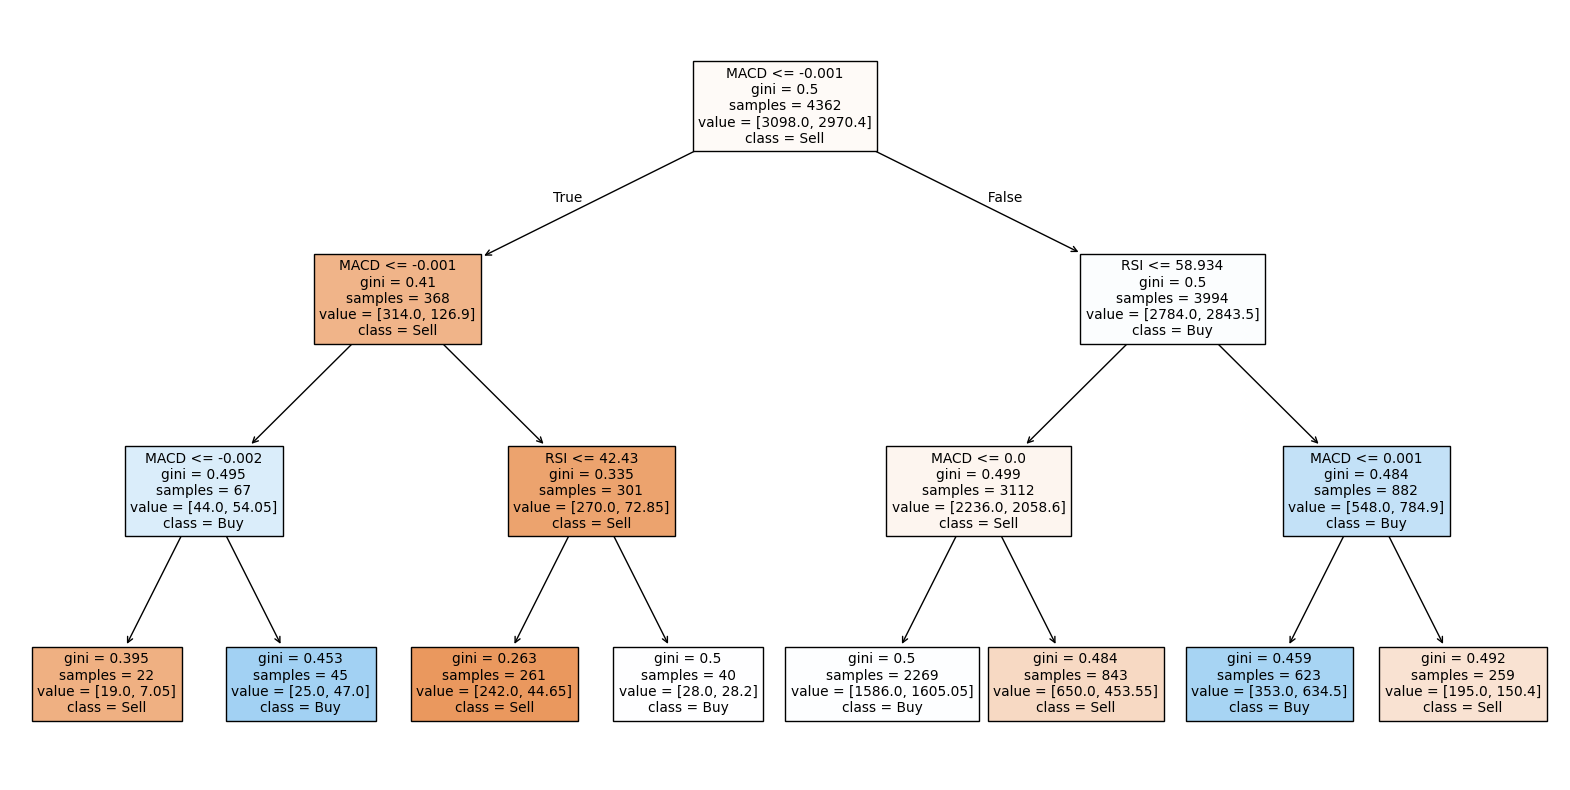

In [ ]:
# Compare feature importance
print("Feature Importance:")
for name, score in zip(feature_cols, final_model.feature_importances_):
    print(f"{name}: {score:.3f}")

# Tree visualization (explainable!)
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(final_model, feature_names=feature_cols, class_names=['Sell','Buy'], 
          max_depth=3, filled=True)
plt.show()